## Libraries

In [2]:
#for calculating lcs
!pip install pylcs

  Using cached https://files.pythonhosted.org/packages/b2/3d/1bcd4daca7fb70311aa46507b74bca8f7ec414ee2d0f8a4d5e0ea2084163/pylcs-0.0.6.tar.gz
  Created wheel for pylcs: filename=pylcs-0.0.6-cp36-cp36m-linux_x86_64.whl size=530525 sha256=f00747dace715023ebdbfdf9d33ea8c1a8235007b41ebd72fb8591b534216f8b
  Stored in directory: /root/.cache/pip/wheels/36/86/08/64aa0fa37646abba3270bd7eb5741e24741f80cd7f3570321d
Successfully built pylcs


In [4]:
!pip install fuzzywuzzy

In [21]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
import pylcs
from PIL import Image

In [ ]:
##mount drive for data
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#setup the path
%cd /content/drive/MyDrive/Quora

In [9]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('/content/drive/MyDrive/Quora Data/df_with_preprocessing_train.csv'):
    df = pd.read_csv("/content/drive/MyDrive/Quora Data/df_with_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_with_preprocessing_train.csv from  running the previous notebook")

In [10]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0


##  Feature Extraction 

In [24]:
def get_token_features(q1, q2):
    """
    ARGS: 
    Q1: THE TEXT OF PREPROCESSED Q1
    Q2: THE TEXT OF PREPROCESSED Q2
    RETURNS THE FEATURES
    """
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = pylcs.lcs(a, b)
    if strs == 0:
        return 0
    else:
        return strs / (min(len(a), len(b)) + 1)

def extract_features(df):
    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [26]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/content/drive/MyDrive/Quora Data/df_with_preprocessing_train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


## Analysis of extracted features </h3>

### Plotting Word clouds

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [32]:
!ls

1.Quora.ipynb			       final_features.rar
2.Quora_Preprocessing.ipynb	       nlp_features_train.csv
3.Q_Mean_W2V.ipynb		       train.csv
4.ML_models.ipynb		       train.db
df_fe_without_preprocessing_train.csv  train_n.txt
distance			       train_p.txt
Distance-0.1.3.tar.gz		       wordcloud-1.3.3-cp36-cp36m-win_amd64.whl
final_features.csv


In [37]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('/content/drive/MyDrive/Quora Data/train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('/content/drive/MyDrive/Quora Data/train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [38]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, '/content/drive/MyDrive/Quora Data/train_p.txt')).read()
textn_w = open(path.join(d, '/content/drive/MyDrive/Quora Data/train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


Word Clouds generated from  duplicate pair question's text

Word Cloud for Duplicate Question pairs


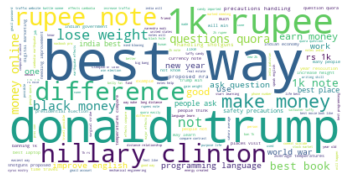

In [39]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Clouds generated from non duplicate pair question's text

Word Cloud for non-Duplicate Question pairs:


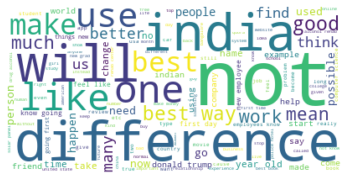

In [40]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Some Words Occur More often in class label 1 compared to class label 0 and vice versa so BOW and TFIDF might be helpful

### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

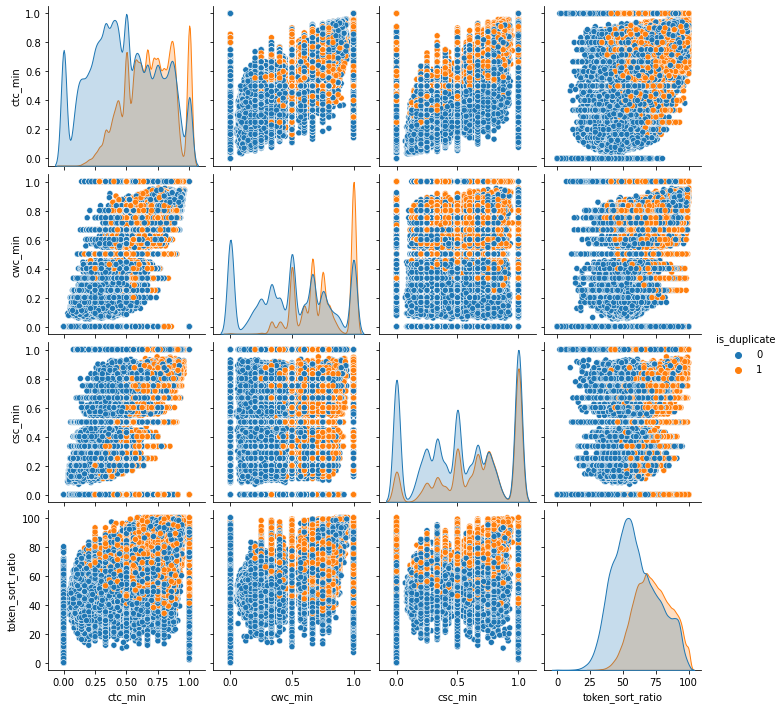

In [41]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

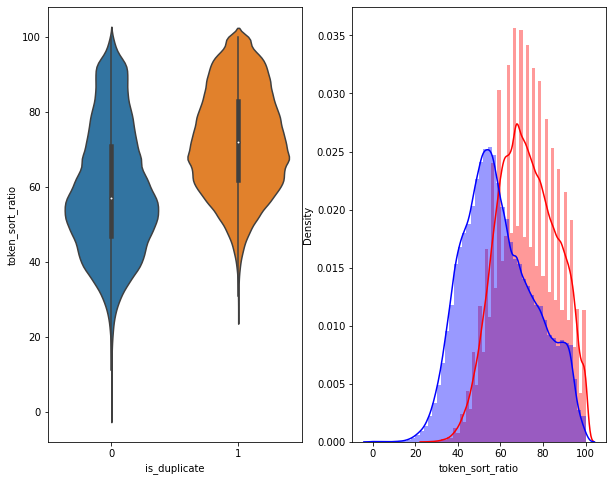

In [42]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

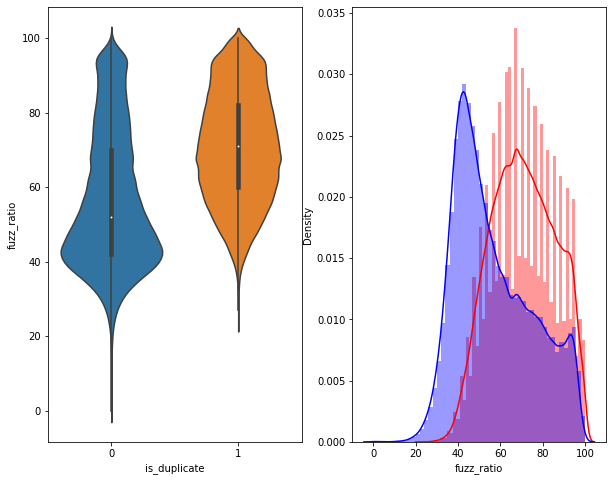

In [43]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()